In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/car_type_detection/

/gdrive/MyDrive/car_type_detection


In [4]:
ls

'bmw serie 1'/      'hyundai tucson'/     polo/
'chevrolet spark'/   logan/               sandero/
'chevroulet aveo'/   megane/             'seat ibiza'/
 clio/              'mercedes class a'/   symbol/
 duster/            'nemo citroen'/      'toyota corolla'/
 Golf/               octavia/            'volkswagen tiguan'/
'hyundai i10'/       picanto/


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [7]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=15
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/car_type_detection",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3235 files belonging to 20 classes.


In [9]:
class_names = dataset.class_names
class_names

['Golf',
 'bmw serie 1',
 'chevrolet spark',
 'chevroulet aveo',
 'clio',
 'duster',
 'hyundai i10',
 'hyundai tucson',
 'logan',
 'megane',
 'mercedes class a',
 'nemo citroen',
 'octavia',
 'picanto',
 'polo',
 'sandero',
 'seat ibiza',
 'symbol',
 'toyota corolla',
 'volkswagen tiguan']

In [10]:
len(dataset)

53

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[186.       188.       183.      ]
  [181.9375   183.9375   178.9375  ]
  [181.6875   183.6875   178.6875  ]
  ...
  [199.625    199.3125   192.25    ]
  [201.75     200.75     195.75    ]
  [205.       204.       199.      ]]

 [[181.125    183.125    178.125   ]
  [177.0625   179.0625   174.0625  ]
  [176.8125   178.8125   173.8125  ]
  ...
  [194.75     194.4375   187.375   ]
  [196.875    195.875    190.875   ]
  [200.125    199.125    194.125   ]]

 [[176.5625   178.5625   173.5625  ]
  [172.5      174.5      169.5     ]
  [172.72266  174.72266  169.72266 ]
  ...
  [192.72266  192.41016  185.34766 ]
  [194.2461   193.2461   188.2461  ]
  [196.9375   195.9375   190.9375  ]]

 ...

 [[ 91.8125    86.8125    80.8125  ]
  [ 95.265625  90.265625  84.265625]
  [ 92.96875   86.59375   80.59375 ]
  ...
  [ 81.921875  77.609375  69.546875]
  [ 98.91406   93.91406   87.91406 ]
  [ 89.875     84.875     78.875   ]]

 [[ 98.1875    93.1875    87.1875  ]
  [ 87.3

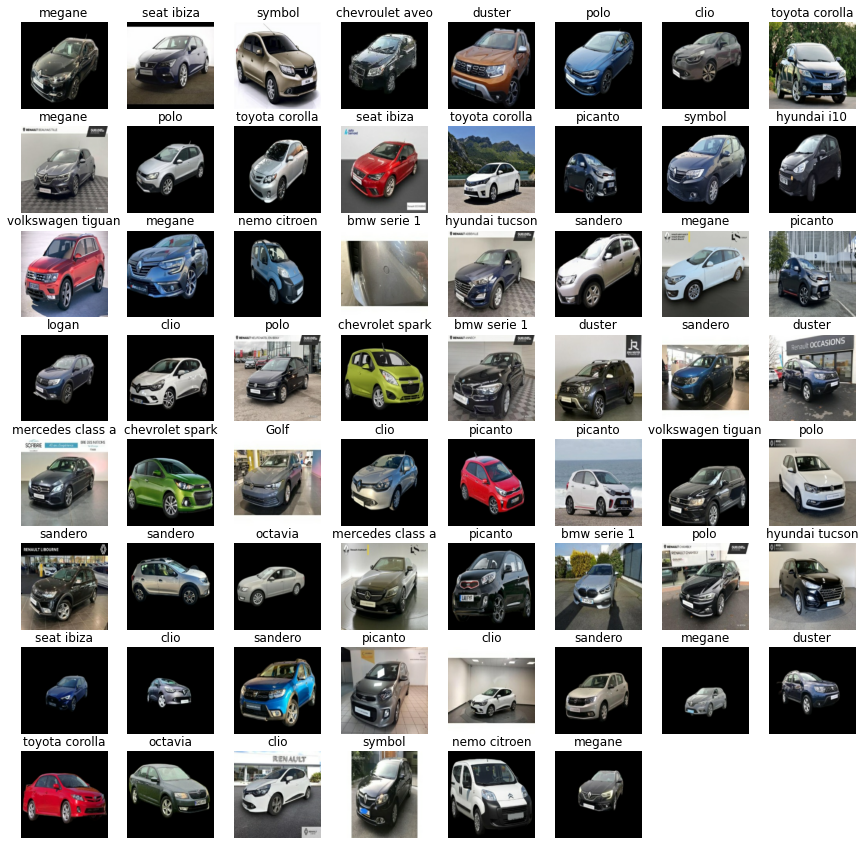

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 20

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (62, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (62, 60, 60, 64)         

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/15
42/42 [==============================] - 285s 7s/step - loss: 2.9414 - accuracy: 0.1061 - val_loss: 2.8978 - val_accuracy: 0.0839
Epoch 2/15
42/42 [==============================] - 270s 6s/step - loss: 2.9082 - accuracy: 0.1132 - val_loss: 2.8320 - val_accuracy: 0.0839
Epoch 3/15
42/42 [==============================] - 276s 7s/step - loss: 2.8636 - accuracy: 0.1206 - val_loss: 2.7422 - val_accuracy: 0.1387
Epoch 4/15
42/42 [==============================] - 273s 7s/step - loss: 2.7311 - accuracy: 0.1774 - val_loss: 2.5152 - val_accuracy: 0.2548
Epoch 5/15
42/42 [==============================] - 277s 7s/step - loss: 2.5364 - accuracy: 0.2397 - val_loss: 2.2077 - val_accuracy: 0.3226
Epoch 6/15
42/42 [==============================] - 273s 6s/step - loss: 2.2574 - accuracy: 0.3200 - val_loss: 1.9698 - val_accuracy: 0.4613
Epoch 7/15
42/42 [==============================] - 278s 7s/step - loss: 1.8674 - accuracy: 0.4403 - val_loss: 1.7203 - val_accuracy: 0.4645
Epoch 8/15
42

In [25]:
model.evaluate(test_ds)

6/6 [==============================] - 22s 2s/step - loss: 0.3066 - accuracy: 0.9435


[0.30662381649017334, 0.9435483813285828]

In [26]:
acc = history.history['accuracy']
loss = history.history['loss']

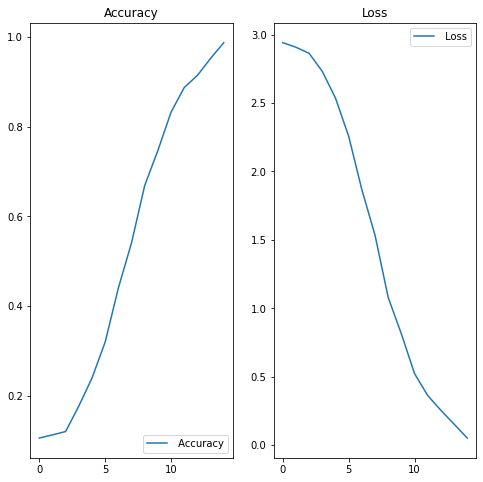

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

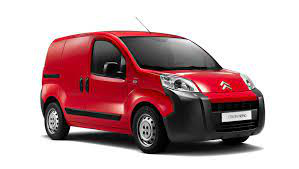

In [28]:
image_path = "/gdrive/My Drive/nemo_citroen.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [29]:
pred = model.predict(scaled_img)

In [30]:
output = class_names[np.argmax(pred)]

In [31]:
output

'hyundai i10'

In [32]:
model.save("car_type_detection.h5")